/tmp/ipython-input-772529431.py:425: UserWarning: Glyph 65085 (\N{PRESENTATION FORM FOR VERTICAL LEFT DOUBLE ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-772529431.py:425: UserWarning: Glyph 65088 (\N{PRESENTATION FORM FOR VERTICAL RIGHT ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65085 (\N{PRESENTATION FORM FOR VERTICAL LEFT DOUBLE ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65088 (\N{PRESENTATION FORM FOR VERTICAL RIGHT ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


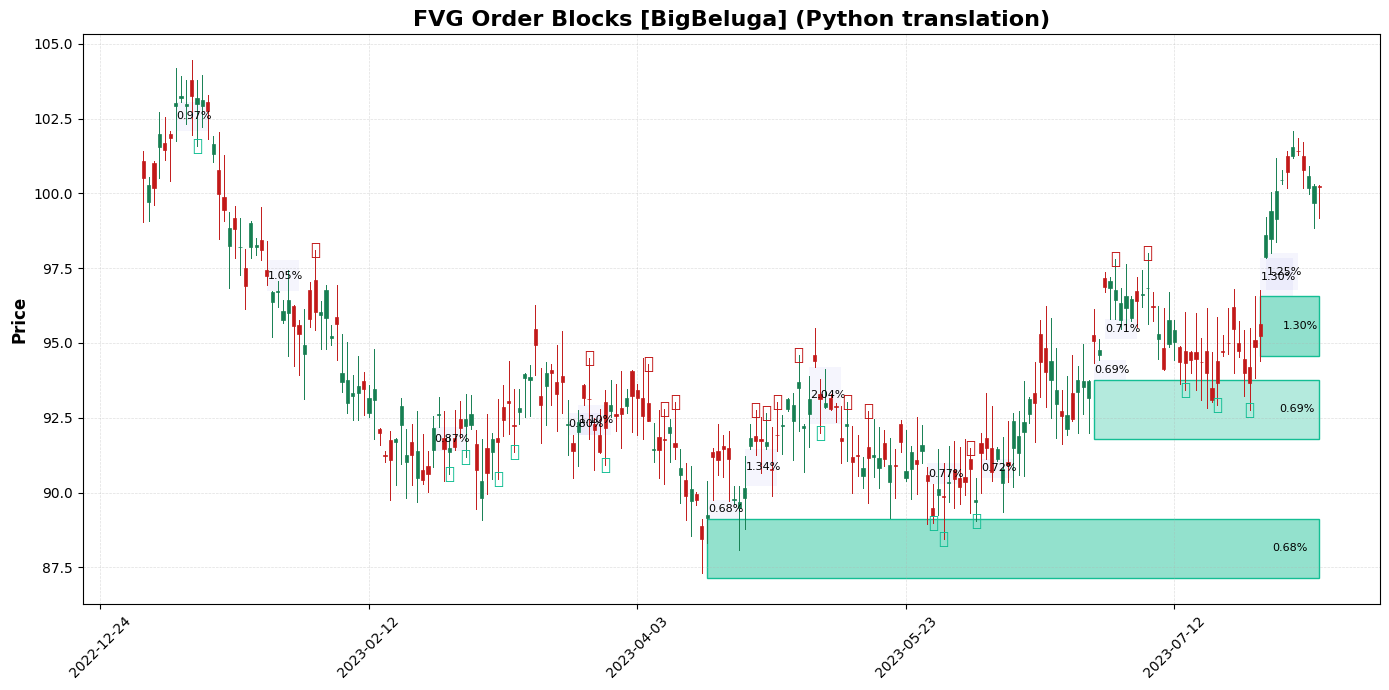

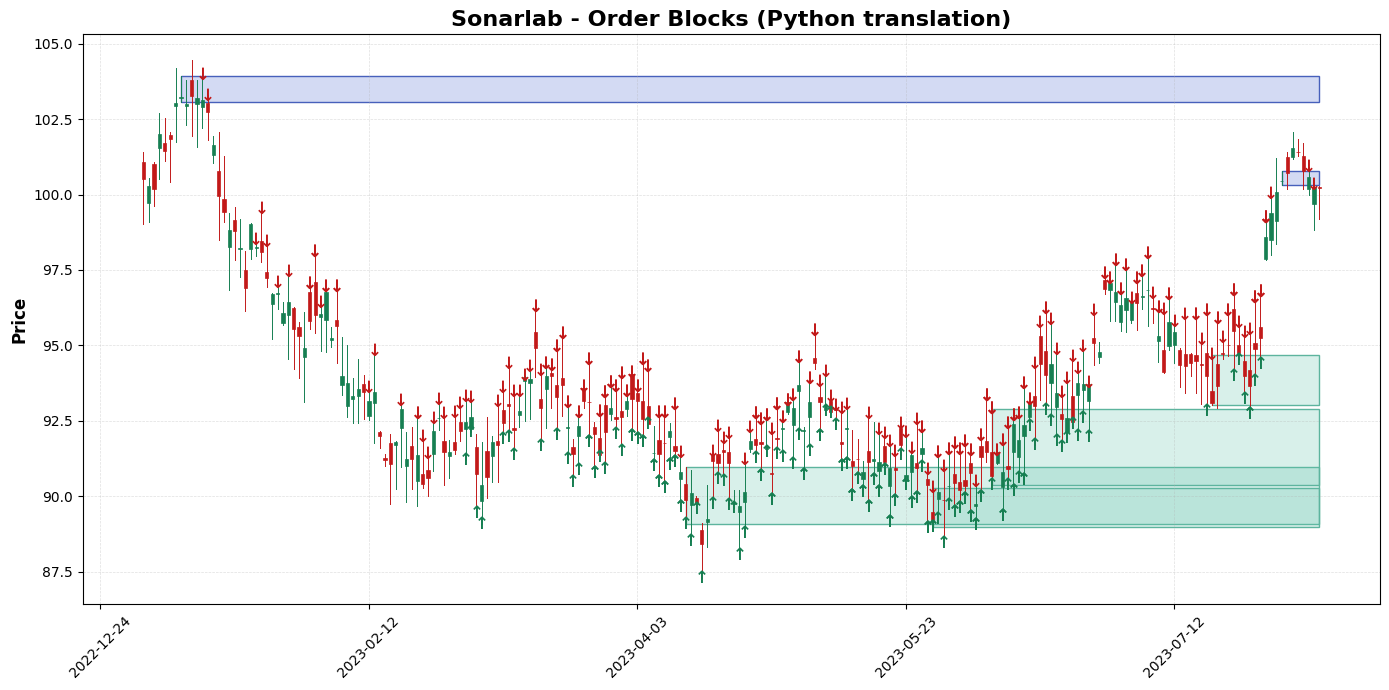

In [1]:
"""
Faithful Python translations of:

1) "FVG Order Blocks [BigBeluga]"  (Pine v5)
   - replicated logic: lookback/filter, isBull_gap/isBear_gap, temporary gap box,
     permanent box top/bottom (using high[2]/low[2] and ATR), boxes arrays,
     broken-level handling, box removal, nested-box cleanup, signals (︽ / ﹀),
     box count limit 'box_amount', gradient-like shading by percent.

2) "Sonarlab - Order Blocks" (Pine v5)
   - replicated logic: sensitivity -> pc ROC-based cross detection,
     OBMitigationType (Close/Wick), create OB at first red/green candle in offsets 4..15,
     cleanup conditions using OBBullMitigation/OBBearMitigation and alerts.

Dummy dataset provided at bottom.
Author translations: ChatGPT
"""

import math
from dataclasses import dataclass
from typing import List, Dict, Tuple, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

# -------------------------
# Helper utilities
# -------------------------
def atr_series(df: pd.DataFrame, period: int = 14) -> pd.Series:
    """Wilder-style ATR approximation: rolling mean of true range for period."""
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(period, min_periods=1).mean()

def hex_to_rgba(hex_color: str, alpha: float = 1.0):
    """Convert '#RRGGBB' to RGBA tuple with alpha in [0,1]."""
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16) / 255.0
    g = int(hex_color[2:4], 16) / 255.0
    b = int(hex_color[4:6], 16) / 255.0
    return (r, g, b, alpha)

def clamp(v, a, b):
    return max(a, min(b, v))

# -------------------------
# 1) FVG Order Blocks [BigBeluga] (full logic)
# -------------------------
class FVGOrderBlocks:
    """
    Python translation of the Pine "FVG Order Blocks [BigBeluga]" indicator.
    Inputs/Defaults mirrored from Pine:
        loockback = 2000
        filter = 0.5
        show_imb = True
        box_amount = 6
        show_broken = False
        show_signal = False
        col_bull = #14be94
        col_bear = rgb(194,25,25) -> #C21919
    """

    def __init__(self,
                 filter_gap: float = 0.5,
                 show_imb: bool = True,
                 box_amount: int = 6,
                 show_broken: bool = False,
                 show_signal: bool = False,
                 col_bull: str = "#14be94",
                 col_bear: str = "#C21919",
                 lookback: int = 2000):
        self.filter_gap = filter_gap
        self.show_imb = show_imb
        self.box_amount = box_amount
        self.show_broken = show_broken
        self.show_signal = show_signal
        self.col_bull = col_bull
        self.col_bear = col_bear
        self.lookback = lookback

        # storage for created "boxes" (dicts)
        self.bull_boxes: List[Dict[str, Any]] = []
        self.bear_boxes: List[Dict[str, Any]] = []
        # temporary boxes for visualizing gaps
        self.temp_boxes: List[Dict[str, Any]] = []
        # signals: list of dicts {index, price, symbol, color}
        self.signals: List[Dict[str, Any]] = []

    def run(self, df: pd.DataFrame):
        """
        df: DataFrame with columns ['Open','High','Low','Close'] indexed by date
        After run, self.bull_boxes, self.bear_boxes and self.signals will be populated.
        """
        n = len(df)
        if n == 0:
            return

        # ATR replicating ta.atr(200)
        atr = atr_series(df, period=200)

        # Filters
        # note: pine uses low-high[2] etc, so we exactly mirror those formulas:
        filt_up = (df['Low'] - df['High'].shift(2)) / df['Low'] * 100
        filt_dn = (df['Low'].shift(2) - df['High']) / df['Low'].shift(2) * 100

        max_up = filt_up.rolling(200, min_periods=1).max()
        max_dn = filt_dn.rolling(200, min_periods=1).max()

        # Vars to mimic isBull_gap/isBear_gap that were var bool in pine
        isBull_gap = False
        isBear_gap = False

        # Iterate bars in chronological order (0..n-1) like pine
        for idx in range(n):
            # check lookback gating: (last_bar_index - bar_index) < loockback
            if (n - 1 - idx) < self.lookback:
                # compute isBull/isBear for this bar exactly as pine
                # guard shifts: ensure idx >= 2 for [2] references
                if idx >= 2:
                    isBull_gap = (df['High'].shift(2).iat[idx] < df['Low'].iat[idx]
                                  and df['High'].shift(2).iat[idx] < df['High'].shift(1).iat[idx]
                                  and df['Low'].shift(2).iat[idx] < df['Low'].iat[idx]
                                  and (filt_up.iat[idx] > self.filter_gap))
                    isBear_gap = (df['Low'].shift(2).iat[idx] > df['High'].iat[idx]
                                  and df['Low'].shift(2).iat[idx] > df['Low'].shift(1).iat[idx]
                                  and df['High'].shift(2).iat[idx] > df['High'].iat[idx]
                                  and (filt_dn.iat[idx] > self.filter_gap))
                else:
                    isBull_gap = False
                    isBear_gap = False
            else:
                isBull_gap = False
                isBear_gap = False

            # --- Logic for Bullish Imbalance (Pine exact reproduction) ---
            if isBull_gap:
                if self.show_imb:
                    # Temporary box representing the raw gap (pine used left=bar_index-1, top=low, right=bar_index+5, bottom=high[2])
                    left = idx - 1
                    right = idx + 5
                    top_v = df['Low'].iat[idx]
                    bottom_v = df['High'].shift(2).iat[idx]
                    # normalize top/bottom (pine uses these values possibly reversed; ensure top>bottom for plotting)
                    top_normal = max(top_v, bottom_v)
                    bottom_normal = min(top_v, bottom_v)
                    temp = {
                        "left": left,
                        "right": min(right, n-1),
                        "top": top_normal,
                        "bottom": bottom_normal,
                        "type": "temp_bull",
                        "percent": filt_up.iat[idx],
                        "alpha": 0.12
                    }
                    self.temp_boxes.append(temp)

                # Permanent box (pine: left=bar_index-1, top=high[2], right=last_bar_index, bottom=high[2]-atr)
                if idx >= 2 and not math.isnan(atr.iat[idx]):
                    top_val = df['High'].shift(2).iat[idx]
                    bottom_val = top_val - atr.iat[idx]
                    percent_val = filt_up.iat[idx]
                    p_norm = percent_val / (max_up.iat[idx] if (not math.isnan(max_up.iat[idx]) and max_up.iat[idx] != 0) else 1.0)
                    # gradient-like alpha: map p_norm to alpha
                    alpha = clamp(0.15 + 0.5 * (p_norm if p_norm>0 else 0), 0.06, 0.7)
                    box = {
                        "left": idx - 1,
                        "right": n - 1,  # will be extended like set_right
                        "top": top_val,
                        "bottom": bottom_val,
                        "type": "bull",
                        "percent": percent_val,
                        "alpha": alpha,
                        "border_color": self.col_bull,
                        "bg_color": self.col_bull,
                        "broken": False,
                        "border_width": 1
                    }
                    self.bull_boxes.append(box)

            # --- Logic for Bearish Imbalance (Pine exact reproduction) ---
            if isBear_gap:
                if self.show_imb:
                    left = idx - 1
                    right = idx + 5
                    top_v = df['High'].iat[idx]
                    bottom_v = df['Low'].shift(2).iat[idx]
                    top_normal = max(top_v, bottom_v)
                    bottom_normal = min(top_v, bottom_v)
                    temp = {
                        "left": left,
                        "right": min(right, n-1),
                        "top": top_normal,
                        "bottom": bottom_normal,
                        "type": "temp_bear",
                        "percent": filt_dn.iat[idx],
                        "alpha": 0.12
                    }
                    self.temp_boxes.append(temp)

                if idx >= 2 and not math.isnan(atr.iat[idx]):
                    top_val = df['Low'].shift(2).iat[idx] + atr.iat[idx]
                    bottom_val = df['Low'].shift(2).iat[idx]
                    percent_val = filt_dn.iat[idx]
                    p_norm = percent_val / (max_dn.iat[idx] if (not math.isnan(max_dn.iat[idx]) and max_dn.iat[idx] != 0) else 1.0)
                    alpha = clamp(0.15 + 0.5 * (p_norm if p_norm>0 else 0), 0.06, 0.7)
                    box = {
                        "left": idx - 1,
                        "right": n - 1,
                        "top": top_val,
                        "bottom": bottom_val,
                        "type": "bear",
                        "percent": percent_val,
                        "alpha": alpha,
                        "border_color": self.col_bear,
                        "bg_color": self.col_bear,
                        "broken": False,
                        "border_width": 1
                    }
                    self.bear_boxes.append(box)

            # --- Adjust right edges at end-of-data (pine does this in barstate.islast)
            # (we replicate behavior by leaving right as n-1, and later when plotting we can optionally extend further)

            # --- Logic to handle broken levels & signals & nested boxes & size limits ---
            # We do these checks at each bar like pine (for current bar 'idx').

            # Bull boxes broken detection & signals
            to_delete_bull_indices = set()
            for bi, box in enumerate(self.bull_boxes):
                # broken if high < box.bottom (pine: if high < box.get_bottom(box_id))
                if df['High'].iat[idx] < box['bottom']:
                    # set border_width 0 and background to chart fg (simulated as nearly opaque grey)
                    box['border_width'] = 0
                    box['bg_color'] = "#E6E6E6"  # chart.fg_color approximation (light grey)
                    box['broken'] = True
                    if not self.show_broken:
                        to_delete_bull_indices.add(bi)

                # signal condition (pine):
                # if low > box.get_top(box_id) and low[1] <= box.get_top(box_id) and not isBull_gap and show_signal
                if self.show_signal and (idx >= 1):
                    if (df['Low'].iat[idx] > box['top'] and df['Low'].shift(1).iat[idx] <= box['top'] and (not isBull_gap)):
                        label_idx = idx - 1
                        price_for_label = df['Low'].shift(1).iat[idx]
                        self.signals.append({"index": label_idx, "price": price_for_label, "symbol": "︽", "color": self.col_bull})

            # remove bull boxes flagged
            if to_delete_bull_indices:
                self.bull_boxes = [b for i,b in enumerate(self.bull_boxes) if i not in to_delete_bull_indices]

            # Nested-bull removal (pine: remove box if another top1 < top and top1 > bottom)
            remove_bull_indices = set()
            for i_outer, box in enumerate(self.bull_boxes):
                for i_inner, box1 in enumerate(self.bull_boxes):
                    if i_outer == i_inner:
                        continue
                    top1 = box1['top']
                    top_ = box['top']
                    bottom1 = box1['bottom']
                    bottom_ = box['bottom']
                    if (top1 < top_) and (top1 > bottom_):
                        # pine: box.delete(box_id) and boxes1.remove(box_id)
                        remove_bull_indices.add(i_outer)
                        break
            if remove_bull_indices:
                self.bull_boxes = [b for i,b in enumerate(self.bull_boxes) if i not in remove_bull_indices]

            # Bear boxes broken detection & signals
            to_delete_bear_indices = set()
            for bi, box in enumerate(self.bear_boxes):
                # broken if low > box.top (pine: if low > box.get_top(box_id))
                if df['Low'].iat[idx] > box['top']:
                    box['border_width'] = 0
                    box['bg_color'] = "#E6E6E6"
                    box['broken'] = True
                    if not self.show_broken:
                        to_delete_bear_indices.add(bi)

                # signal condition (pine):
                # if high < box.get_bottom(box_id) and high[1] >= box.get_bottom(box_id) and not isBear_gap and show_signal
                if self.show_signal and (idx >= 1):
                    if (df['High'].iat[idx] < box['bottom'] and df['High'].shift(1).iat[idx] >= box['bottom'] and (not isBear_gap)):
                        label_idx = idx - 1
                        price_for_label = df['High'].shift(1).iat[idx]
                        self.signals.append({"index": label_idx, "price": price_for_label, "symbol": "﹀", "color": self.col_bear})

            if to_delete_bear_indices:
                self.bear_boxes = [b for i,b in enumerate(self.bear_boxes) if i not in to_delete_bear_indices]

            # Nested-bear removal (same logic pattern)
            remove_bear_indices = set()
            for i_outer, box in enumerate(self.bear_boxes):
                for i_inner, box1 in enumerate(self.bear_boxes):
                    if i_outer == i_inner:
                        continue
                    top1 = box1['top']
                    top_ = box['top']
                    bottom1 = box1['bottom']
                    bottom_ = box['bottom']
                    if (top1 < top_) and (top1 > bottom_):
                        remove_bear_indices.add(i_outer)
                        break
            if remove_bear_indices:
                self.bear_boxes = [b for i,b in enumerate(self.bear_boxes) if i not in remove_bear_indices]

            # Limit the number of displayed boxes to the specified amount (pine logic)
            while len(self.bull_boxes) >= self.box_amount:
                # pine: if boxes1.size() >= box_amount box.delete(boxes1.shift())
                # shift() removes first element; so pop(0)
                self.bull_boxes.pop(0)
            while len(self.bear_boxes) >= self.box_amount:
                self.bear_boxes.pop(0)

        # final "barstate.islast" mimic: extend boxes slightly to the right (pine set_right to bar_index+15)
        # we will extend to n-1 + 15 to mimic
        right_ext = n - 1 + 15
        for b in self.bull_boxes:
            b['right'] = right_ext
        for b in self.bear_boxes:
            b['right'] = right_ext
        for t in self.temp_boxes:
            t['right'] = min(t['right'], n - 1)  # temp limited

    def plot(self, df: pd.DataFrame, title: str = "FVG Order Blocks [BigBeluga]"):
        """
        Draw candles and boxes using matplotlib. Uses self.bull_boxes/self.bear_boxes/self.temp_boxes/self.signals created by run().
        """
        dates = list(df.index)
        # prepare figure
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.set_title(title, fontsize=16, fontweight='bold')

        # draw candlesticks manually
        width = 0.6  # days
        candle_width = 0.6
        for i, dt in enumerate(dates):
            o = df['Open'].iat[i]
            h = df['High'].iat[i]
            l = df['Low'].iat[i]
            c = df['Close'].iat[i]
            color = '#167F52' if c >= o else '#C21919'  # green / red using bull/bear
            # wick
            ax.plot([mdates.date2num(dt), mdates.date2num(dt)], [l, h], color=color, linewidth=0.7)
            # body
            bottom = min(o, c)
            height = abs(c - o)
            rect = Rectangle((mdates.date2num(dt) - candle_width/2, bottom),
                             candle_width, max(height, 0.0001), facecolor=color, edgecolor=color, linewidth=0.5, zorder=2)
            ax.add_patch(rect)

        # draw permanent bull boxes (green-ish)
        for b in self.bull_boxes:
            left = mdates.date2num(dates[b['left']]) if b['left'] >= 0 and b['left'] < len(dates) else mdates.date2num(dates[0])
            # compute right x coordinate, if right index beyond last date, extend by fraction of day
            right_idx = min(b['right'], len(dates)-1)
            right = mdates.date2num(dates[right_idx]) + 0.0  # no extra extended days for neatness
            top = b['top']
            bottom = b['bottom']
            face_rgba = hex_to_rgba(b['bg_color'], b['alpha'])
            edge_rgba = hex_to_rgba(b['border_color'], 1.0 if b['border_width']>0 else 0.0)
            rect = Rectangle((left, bottom), right - left, top - bottom, facecolor=face_rgba, edgecolor=edge_rgba, linewidth=b['border_width'], zorder=1)
            ax.add_patch(rect)
            # add percent text on box right (similar to text_halign=right)
            try:
                pct_text = f"{b['percent']:.2f}%"
            except:
                pct_text = ""
            ax.text(right - (right-left)*0.02, (top+bottom)/2, pct_text, verticalalignment='center', horizontalalignment='right', fontsize=8, color='black', zorder=3)

        # draw permanent bear boxes (red-ish)
        for b in self.bear_boxes:
            left = mdates.date2num(dates[b['left']]) if b['left'] >= 0 and b['left'] < len(dates) else mdates.date2num(dates[0])
            right_idx = min(b['right'], len(dates)-1)
            right = mdates.date2num(dates[right_idx])
            top = b['top']
            bottom = b['bottom']
            face_rgba = hex_to_rgba(b['bg_color'], b['alpha'])
            edge_rgba = hex_to_rgba(b['border_color'], 1.0 if b['border_width']>0 else 0.0)
            rect = Rectangle((left, bottom), right - left, top - bottom, facecolor=face_rgba, edgecolor=edge_rgba, linewidth=b['border_width'], zorder=1)
            ax.add_patch(rect)
            try:
                pct_text = f"{b['percent']:.2f}%"
            except:
                pct_text = ""
            ax.text(right - (right-left)*0.02, (top+bottom)/2, pct_text, verticalalignment='center', horizontalalignment='right', fontsize=8, color='black', zorder=3)

        # draw temp boxes (light)
        for t in self.temp_boxes:
            if t['left'] < 0 or t['right'] < 0:
                continue
            left = mdates.date2num(dates[max(0, t['left'])])
            right = mdates.date2num(dates[min(len(dates)-1, t['right'])])
            top = t['top']
            bottom = t['bottom']
            rect = Rectangle((left, bottom), right - left, top - bottom, facecolor=(0.7,0.7,0.95,t['alpha']), edgecolor='none', zorder=0)
            ax.add_patch(rect)
            # draw percent text (if provided)
            try:
                pct_text = f"{t['percent']:.2f}%"
            except:
                pct_text = ""
            ax.text(left + (right-left)*0.02, (top+bottom)/2, pct_text, verticalalignment='center', horizontalalignment='left', fontsize=8, color='black', zorder=2)

        # draw signals labels (︽ or ﹀)
        for s in self.signals:
            idx = s['index']
            if idx < 0 or idx >= len(dates):
                continue
            x = mdates.date2num(dates[idx])
            y = s['price']
            ax.text(x, y, s['symbol'], fontsize=12, fontweight='bold', ha='center', va='center', color=s['color'], zorder=4)

        ax.set_ylabel("Price", fontsize=12, fontweight='bold')
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# -------------------------
# 2) Sonarlab - Order Blocks (full logic)
# -------------------------
class SonarlabOrderBlocks:
    """
    Python translation of "Sonarlab - Order Blocks".
    Mirrors:
     - sensitivity (28 default) -> sens = sensitivity/100
     - OBMitigationType: "Close" or "Wick"
     - OBBullMitigation = Close[1] if Close else Low
     - OBBearMitigation = Close[1] if Close else High
     - pc = (open - open[4]) / open[4] * 100
     - ta.crossunder(pc, -sens) -> ob_created = True, cross_index := bar_index
     - ta.crossover(pc, sens) -> ob_created_bull = True, cross_index := bar_index
     - For creation, ensure gap from previously created OBs: cross_index - cross_index[1] > 5 (replicated by ensuring i - last_ob_idx > 5)
     - loops offsets 4..15 to find first RED/GREEN candle to place OB
     - cleanup and alert rules replicated exactly
    """

    def __init__(self,
                 sensitivity: int = 28,
                 OBMitigationType: str = "Close",
                 col_bullish: str = "#5db49e",
                 col_bullish_ob: str = "#64C4AC",  # will apply alpha
                 col_bearish: str = "#4760bb",
                 col_bearish_ob: str = "#506CD3",
                 buy_alert: bool = True,
                 sell_alert: bool = True):
        self.sensitivity = sensitivity
        self.sens = sensitivity / 100.0
        self.OBMitigationType = OBMitigationType
        self.col_bullish = col_bullish
        self.col_bullish_ob = col_bullish_ob
        self.col_bearish = col_bearish
        self.col_bearish_ob = col_bearish_ob
        self.buy_alert = buy_alert
        self.sell_alert = sell_alert

        # storage
        self.long_boxes: List[Dict[str, Any]] = []
        self.short_boxes: List[Dict[str, Any]] = []
        self.signals: List[Dict[str, Any]] = []

    def run(self, df: pd.DataFrame):
        n = len(df)
        if n == 0:
            return

        # pc series
        pc = (df['Open'] - df['Open'].shift(4)) / df['Open'].shift(4) * 100

        # mitigation as series
        if self.OBMitigationType == "Close":
            OBBullMitigation = df['Close'].shift(1)
            OBBearMitigation = df['Close'].shift(1)
        else:
            OBBullMitigation = df['Low']  # using low (Wick)
            OBBearMitigation = df['High']  # using high (Wick)

        # emulate pine boolean/state variables
        ob_created = False
        ob_created_bull = False
        last_cross_index = None  # like cross_index var in pine (we store last used cross creation index)

        # iterate bars
        for idx in range(n):
            # detect crossunder (pc crosses under -sens)
            if idx >= 1:
                prev_pc = pc.iat[idx-1] if not np.isnan(pc.iat[idx-1]) else None
                cur_pc = pc.iat[idx] if not np.isnan(pc.iat[idx]) else None
                # crossunder: previous >= -sens and current < -sens
                if (prev_pc is not None and cur_pc is not None and prev_pc >= -self.sens and cur_pc < -self.sens):
                    ob_created = True
                    last_cross_index = idx  # cross_index := bar_index
                # crossover: previous <= sens and current > sens
                if (prev_pc is not None and cur_pc is not None and prev_pc <= self.sens and cur_pc > self.sens):
                    ob_created_bull = True
                    last_cross_index = idx

            # -------------------------------
            # Bearish OB Creation (pine logic)
            # -------------------------------
            if ob_created:
                # pine: if ob_created and cross_index - cross_index[1] > 5
                # We simulate by ensuring at least 6 bars since the last created cross (if we have prior creation)
                # But pine's cross_index[1] is previous value; here we simply use last_ob_creation_idx to guard multiple within 5 bars.
                # We'll track 'last_created_ob_idx' to enforce spacing. Simpler: require idx - last_created_ob_idx > 5 if exists.
                pass

            # We'll maintain a small variable to hold the last created OB global index to enforce spacing
            # (initialize on first creation)
            # We'll create OB when ob_created True and (no OB created recently within 5 bars)
            if ob_created:
                # find if there was a previously created OB (either bull or bear)
                # to match pine condition cross_index - cross_index[1] > 5, we require idx - prev_cross_index > 5
                # We don't have cross_index[1]; we will use a local guard: don't create if any creation occurred within last 5 bars.
                recently_created = False
                # look for last created OB index in our short/long boxes: use last created's 'created_at' if present
                last_created_idx = None
                if len(self.short_boxes) > 0:
                    last_created_idx = max([b.get('created_at', -9999) for b in self.short_boxes])
                if len(self.long_boxes) > 0:
                    last_created_idx = max(last_created_idx if last_created_idx is not None else -9999,
                                           max([b.get('created_at', -9999) for b in self.long_boxes]))
                if last_created_idx is not None and (idx - last_created_idx) <= 5:
                    recently_created = True

                if not recently_created:
                    # loop through offsets 4..15 and find first GREEN candle (close[i] > open[i]) as in pine
                    last_green_idx = None
                    for off in range(4, 16):
                        bar_idx = idx - off
                        if bar_idx >= 0:
                            if df['Close'].iat[bar_idx] > df['Open'].iat[bar_idx]:
                                last_green_idx = bar_idx
                                break
                    if last_green_idx is not None:
                        drawShortBox = {
                            "left": last_green_idx,
                            "right": n - 1,
                            "top": df['High'].iat[last_green_idx],
                            "bottom": df['Low'].iat[last_green_idx],
                            "bg_color": self.col_bearish_ob,
                            "border_color": self.col_bearish,
                            "created_at": idx,
                            "type": "bearish"
                        }
                        self.short_boxes.append(drawShortBox)
                # reset ob_created flag in pine it's not reset explicitly; but next bars ob_created may be reset by cross detection
                ob_created = False

            # -------------------------------
            # Bullish OB Creation
            # -------------------------------
            if ob_created_bull:
                last_created_idx = None
                if len(self.short_boxes) > 0:
                    last_created_idx = max([b.get('created_at', -9999) for b in self.short_boxes])
                if len(self.long_boxes) > 0:
                    last_created_idx = max(last_created_idx if last_created_idx is not None else -9999,
                                           max([b.get('created_at', -9999) for b in self.long_boxes]))
                recently_created = False
                if last_created_idx is not None and (idx - last_created_idx) <= 5:
                    recently_created = True

                if not recently_created:
                    last_red_idx = None
                    for off in range(4, 16):
                        bar_idx = idx - off
                        if bar_idx >= 0:
                            if df['Close'].iat[bar_idx] < df['Open'].iat[bar_idx]:
                                last_red_idx = bar_idx
                                break
                    if last_red_idx is not None:
                        drawLongBox = {
                            "left": last_red_idx,
                            "right": n - 1,
                            "top": df['High'].iat[last_red_idx],
                            "bottom": df['Low'].iat[last_red_idx],
                            "bg_color": self.col_bullish_ob,
                            "border_color": self.col_bullish,
                            "created_at": idx,
                            "type": "bullish"
                        }
                        self.long_boxes.append(drawLongBox)
                ob_created_bull = False

            # -----------------
            # Bearish OB cleanup & alerts (pine)
            # -----------------
            # if array.size(shortBoxes) > 0
            if len(self.short_boxes) > 0:
                # iterate backwards as pine does
                for j in range(len(self.short_boxes)-1, -1, -1):
                    sbox = self.short_boxes[j]
                    top = sbox['top']
                    bot = sbox['bottom']
                    # If the OBBearMitigation > top -> remove the OB
                    # (pine: if OBBearMitigation > top array.remove & box.delete)
                    # OBBearMitigation is a series: check current idx value
                    val = OBBearMitigation.iat[idx] if idx < len(OBBearMitigation) else None
                    if (val is not None) and (not np.isnan(val)) and (val > top):
                        # remove
                        self.short_boxes.pop(j)
                        continue
                    # Alerts
                    if (df['High'].iat[idx] > bot) and self.sell_alert:
                        # replicate alert('Price inside Bearish OB') once per bar: we simply append signal
                        self.signals.append({"index": idx, "price": df['High'].iat[idx], "signal": "sell", "type": "bearish"})

            # -----------------
            # Bullish OB cleanup & alerts (pine)
            # -----------------
            if len(self.long_boxes) > 0:
                for j in range(len(self.long_boxes)-1, -1, -1):
                    lbox = self.long_boxes[j]
                    bot = lbox['bottom']
                    top = lbox['top']
                    val = OBBullMitigation.iat[idx] if idx < len(OBBullMitigation) else None
                    if (val is not None) and (not np.isnan(val)) and (val < bot):
                        self.long_boxes.pop(j)
                        continue
                    if (df['Low'].iat[idx] < top) and self.buy_alert:
                        self.signals.append({"index": idx, "price": df['Low'].iat[idx], "signal": "buy", "type": "bullish"})


    def plot(self, df: pd.DataFrame, title: str = "Sonarlab - Order Blocks"):
        dates = list(df.index)
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.set_title(title, fontsize=16, fontweight='bold')
        # draw candles
        width = 0.6
        for i, dt in enumerate(dates):
            o = df['Open'].iat[i]
            h = df['High'].iat[i]
            l = df['Low'].iat[i]
            c = df['Close'].iat[i]
            color = '#167F52' if c >= o else '#C21919'
            ax.plot([mdates.date2num(dt), mdates.date2num(dt)], [l, h], color=color, linewidth=0.7)
            rect = Rectangle((mdates.date2num(dt) - width/2, min(o, c)), width, max(abs(c-o), 0.0001), facecolor=color, edgecolor=color, linewidth=0.5, zorder=2)
            ax.add_patch(rect)

        # draw long_boxes (bullish)
        for b in self.long_boxes:
            left = mdates.date2num(dates[b['left']])
            right = mdates.date2num(dates[min(b['right'], len(dates)-1)])
            top = b['top']
            bottom = b['bottom']
            face_rgba = hex_to_rgba(b['bg_color'], 0.25)
            edge_rgba = hex_to_rgba(b['border_color'], 1.0)
            rect = Rectangle((left, bottom), right - left, top - bottom, facecolor=face_rgba, edgecolor=edge_rgba, linewidth=1, zorder=1)
            ax.add_patch(rect)

        # draw short_boxes (bearish)
        for b in self.short_boxes:
            left = mdates.date2num(dates[b['left']])
            right = mdates.date2num(dates[min(b['right'], len(dates)-1)])
            top = b['top']
            bottom = b['bottom']
            face_rgba = hex_to_rgba(b['bg_color'], 0.25)
            edge_rgba = hex_to_rgba(b['border_color'], 1.0)
            rect = Rectangle((left, bottom), right - left, top - bottom, facecolor=face_rgba, edgecolor=edge_rgba, linewidth=1, zorder=1)
            ax.add_patch(rect)

        # draw alerts signals
        for s in self.signals:
            idx = s['index']
            if idx < 0 or idx >= len(dates):
                continue
            x = mdates.date2num(dates[idx])
            y = s['price']
            sym = '↑' if s['signal'] == 'buy' else '↓'
            color = '#167F52' if s['signal'] == 'buy' else '#C21919'
            ax.text(x, y, sym, fontsize=12, color=color, fontweight='bold', ha='center', va='center', zorder=4)

        ax.set_ylabel("Price", fontsize=12, fontweight='bold')
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# -------------------------
# Dummy dataset and run examples
# -------------------------
def make_dummy_ohlc(n=300, seed=42, start_price=100.0, freq='30min'):
    """
    Create dummy OHLC data similar to what you've been using.
    Output DataFrame has columns: Open, High, Low, Close indexed by datetime.
    """
    np.random.seed(seed)
    dates = pd.date_range("2023-01-01", periods=n, freq='D')  # daily data, user can change
    base = np.cumsum(np.random.randn(n) * 0.8) + start_price
    open_ = base + np.random.randn(n) * 0.3
    close = base + np.random.randn(n) * 0.3
    high = np.maximum(open_, close) + np.random.rand(n) * 1.5
    low = np.minimum(open_, close) - np.random.rand(n) * 1.5

    df = pd.DataFrame({"Open": open_, "High": high, "Low": low, "Close": close}, index=dates)
    return df

if __name__ == "__main__":
    # create a dummy dataset
    df = make_dummy_ohlc(n=220)

    # 1) FVG Order Blocks (BigBeluga)
    fvg = FVGOrderBlocks(
        filter_gap=0.52,   # same default you had shown earlier in sample
        show_imb=True,
        box_amount=6,
        show_broken=False,
        show_signal=True,
        col_bull="#14be94",
        col_bear="#C21919",
        lookback=2000
    )
    fvg.run(df)
    # Now plot - shows candlesticks, permanent and temporary boxes, and labels
    fvg.plot(df, title="FVG Order Blocks [BigBeluga] (Python translation)")

    # 2) Sonarlab - Order Blocks
    son = SonarlabOrderBlocks(
        sensitivity=28,
        OBMitigationType="Close",
        col_bullish="#5db49e",
        col_bullish_ob="#64C4AC",
        col_bearish="#4760bb",
        col_bearish_ob="#506CD3",
        buy_alert=True,
        sell_alert=True
    )
    son.run(df)
    son.plot(df, title="Sonarlab - Order Blocks (Python translation)")
